## 10.4 딥러닝 기반 Q-Learning을 이용하는 강화학습

- 관련 패키지 불러오기 

In [2]:
# 기본 패키지
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt 

In [3]:
# 강화학습 환경 패키지
import gym

In [4]:
# 인공지능 패키지: 텐서플로, 케라스 
# 호환성을 위해 텐스플로에 포함된 케라스를 불러옴 
import tensorflow as tf # v2.4.1 at 7/25/2021
from tensorflow import keras # v2.4.0 at 7/25/2021
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

- Q 함수를 위한 뉴럴넷 구성하기

In [5]:
def create_q_model(num_states, num_actions):
    inputs = Input(shape=(num_states,))
    layer = Dense(32, activation="relu")(inputs)
    layer = Dense(16, activation="relu")(layer)
    action = Dense(num_actions, activation="linear")(layer)
    return Model(inputs=inputs, outputs=action)

In [6]:
model = create_q_model(4,2)
model.summary()

2021-10-16 21:19:49.912474: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-10-16 21:19:49.959801: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-10-16 21:19:49.960254: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1050 computeCapability: 6.1
coreClock: 1.455GHz coreCount: 5 deviceMemorySize: 2.00GiB deviceMemoryBandwidth: 104.43GiB/s
2021-10-16 21:19:49.961762: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-10-16 21:19:49.984308: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-10-16 21:19:50.001283: I tensorflow/stream_executor

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
Total params: 722
Trainable params: 722
Non-trainable params: 0
_________________________________________________________________


- Q함수 뉴럴넷의 학습에 필요한 코드 작성

In [7]:
def get_env_model(id='CartPole-v1'):
    env = gym.make(id)
    num_states = env.observation_space.shape[0]
    num_actions = env.action_space.n
    model = create_q_model(num_states, num_actions)
    return env, model

In [8]:
def train(model):
    state_size = 4
    action_size = 2        
    states = np.zeros((10,state_size), dtype=np.float32)
    with tf.GradientTape() as tape:
        predicts = model(states)

In [9]:
env, model = get_env_model()
train(model)
print('Simple processing used in training is completed!')

2021-10-16 21:19:52.415639: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


Simple processing used in training is completed!


In [10]:
class World_00:
    def __init__(self):
        self.get_env_model()

    def get_env_model(self):
        self.env = gym.make('CartPole-v1')
        self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.n
        self.model = create_q_model(self.num_states, self.num_actions)
        # print(self.model.summary())

    def train(self):        
        states = np.zeros((10,self.num_states), dtype=np.float32)
        with tf.GradientTape() as tape:
            predicts = self.model(states)

new_world = World_00()
new_world.train()
print('Simple processing used in training is completed!')

Simple processing used in training is completed!


In [11]:
def env_test_model_memory(memory, env, model, n_episodes=1000, 
        flag_render=False):
    for e in range(n_episodes):
        done = False
        score = 0
        s = env.reset()
        while not done:
            s_array = np.array(s).reshape((1,-1))
            Qsa = model.predict(s_array)[0]
            a = np.argmax(Qsa)
            next_s, r, done, _ = env.step(a)
            if flag_render:
                env.render()
            score += r
            memory.append([s,a,r,next_s,done])
        print(f'Episode: {e:5d} -->  Score: {score:3.1f}')
    print('Notice that the max score is set to 500.0 in CartPole-v1')

In [12]:
def list_rotate(l):
    return list(zip(*l))

In [13]:
class World_01(World_00):
    def __init__(self):
        World_00.__init__(self)
        self.memory = deque(maxlen=2000)
        self.N_batch = 64
        self.t_model = create_q_model(self.num_states, self.num_actions)
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.optimizer = Adam(lr=self.learning_rate)

    def trial(self, flag_render=False):
        env_test_model_memory(self.memory, self.env,
            self.model, n_episodes=10, flag_render=flag_render)
        print(len(self.memory))

    def train_memory(self):
        if len(self.memory) >= self.N_batch:
            memory_batch = random.sample(self.memory, self.N_batch)
            s_l,a_l,r_l,next_s_l,done_l = [np.array(x) for x in list_rotate(memory_batch)]
            model_w = self.model.trainable_variables
            with tf.GradientTape() as tape:
                Qsa_pred_l = self.model(s_l.astype(np.float32))
                a_l_onehot = tf.one_hot(a_l, self.num_actions)
                Qs_a_pred_l = tf.reduce_sum(a_l_onehot * Qsa_pred_l, 
                                             axis=1)    

                Qsa_tpred_l = self.t_model(next_s_l.astype(np.float32)) 
                Qsa_tpred_l = tf.stop_gradient(Qsa_tpred_l)

                max_Q_next_s_a_l = np.amax(Qsa_tpred_l, axis=-1)
                Qs_a_l = r_l + (1 - done_l) * self.discount_factor * max_Q_next_s_a_l
                loss = tf.reduce_mean(tf.square(Qs_a_l - Qs_a_pred_l))
                grads = tape.gradient(loss, model_w)
                self.optimizer.apply_gradients(zip(grads, model_w))

In [14]:
new_world = World_01()
new_world.trial()
new_world.train_memory()
new_world.env.close()
print('Completed!')

Episode:     0 -->  Score: 10.0
Episode:     1 -->  Score: 9.0
Episode:     2 -->  Score: 9.0
Episode:     3 -->  Score: 9.0
Episode:     4 -->  Score: 9.0
Episode:     5 -->  Score: 9.0
Episode:     6 -->  Score: 10.0
Episode:     7 -->  Score: 10.0
Episode:     8 -->  Score: 10.0
Episode:     9 -->  Score: 9.0
Notice that the max score is set to 500.0 in CartPole-v1
94
Completed!


In [15]:
class World_02(World_01):
    def __init__(self):
        World_01.__init__(self)
        self.epsilon = 0.2
    
    def update_t_model(self):
        self.t_model.set_weights(self.model.get_weights())

    def best_action(self, s):
        if random.random() <= self.epsilon:
            return random.randrange(self.num_actions)
        else:
            s_array = np.array(s).reshape((1,-1))
            Qsa = self.model.predict(s_array)[0]
            return np.argmax(Qsa)

    def trials(self, n_episodes=100, flag_render=False):
        memory = self.memory
        env = self.env
        model = self.model
        score_l = []
        for e in range(n_episodes):
            done = False
            score = 0
            s = env.reset()
            while not done:                
                a = self.best_action(s)
                next_s, r, done, _ = env.step(a)
                if flag_render:
                    env.render()
                score += r
                memory.append([s,a,r,next_s,done])
                # self.train_memory()     
                s = next_s
                self.train_memory()                 
            self.update_t_model()
            print(f'Episode: {e:5d} -->  Score: {score:3.1f}') 
            score_l.append(score)            
        return score_l

In [16]:
new_world = World_02()
score_l = new_world.trials(n_episodes=50)
new_world.env.close()
np.save('score_l.npy', score_l)

Episode:     0 -->  Score: 12.0
Episode:     1 -->  Score: 12.0
Episode:     2 -->  Score: 13.0
Episode:     3 -->  Score: 9.0
Episode:     4 -->  Score: 24.0
Episode:     5 -->  Score: 10.0
Episode:     6 -->  Score: 12.0
Episode:     7 -->  Score: 9.0
Episode:     8 -->  Score: 11.0
Episode:     9 -->  Score: 8.0
Episode:    10 -->  Score: 8.0
Episode:    11 -->  Score: 8.0
Episode:    12 -->  Score: 12.0
Episode:    13 -->  Score: 11.0
Episode:    14 -->  Score: 11.0
Episode:    15 -->  Score: 10.0
Episode:    16 -->  Score: 12.0
Episode:    17 -->  Score: 8.0
Episode:    18 -->  Score: 15.0
Episode:    19 -->  Score: 10.0
Episode:    20 -->  Score: 9.0
Episode:    21 -->  Score: 14.0
Episode:    22 -->  Score: 14.0
Episode:    23 -->  Score: 14.0
Episode:    24 -->  Score: 9.0
Episode:    25 -->  Score: 14.0
Episode:    26 -->  Score: 11.0
Episode:    27 -->  Score: 12.0
Episode:    28 -->  Score: 16.0
Episode:    29 -->  Score: 27.0
Episode:    30 -->  Score: 13.0
Episode:    31 -

---
### 전체코드 (분할 버전)

In [4]:
l = [[1,2],[3,4],[5,6]]
list(zip(*l))

[(1, 3, 5), (2, 4, 6)]

In [4]:
# 기본 패키지
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt 

# 강화학습 환경 패키지
import gym

# 인공지능 패키지: 텐서플로, 케라스 
# 호환성을 위해 텐스플로에 포함된 케라스를 불러옴 
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [4]:
def create_q_model(num_states, num_actions):
    inputs = Input(shape=(num_states,))
    layer = Dense(32, activation="relu")(inputs)
    layer = Dense(16, activation="relu")(layer)
    action = Dense(num_actions, activation="linear")(layer)
    return Model(inputs=inputs, outputs=action)

def list_rotate(l):
    return list(zip(*l))

In [4]:
class WorldFull():
    def __init__(self):
        self.get_env_model() #? 
        
        self.memory = deque(maxlen=2000)
        self.N_batch = 64
        self.t_model = create_q_model(self.num_states, self.num_actions)
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.optimizer = Adam(lr=self.learning_rate)
        
        self.epsilon = 0.2
        
    def get_env_model(self):
        self.env = gym.make('CartPole-v1')
        self.num_states = self.env.observation_space.shape[0]
        self.num_actions = self.env.action_space.n
        self.model = create_q_model(self.num_states, self.num_actions)
    
    def update_t_model(self):
        self.t_model.set_weights(self.model.get_weights())

    def best_action(self, s):
        if random.random() <= self.epsilon:
            return random.randrange(self.num_actions)
        else:
            s_array = np.array(s).reshape((1,-1))
            Qsa = self.model.predict(s_array)[0]
            return np.argmax(Qsa)

    def train_memory(self):
        if len(self.memory) >= self.N_batch:
            memory_batch = random.sample(self.memory, self.N_batch)
            s_l,a_l,r_l,next_s_l,done_l = [np.array(x) for x in list_rotate(memory_batch)]
            model_w = self.model.trainable_variables
            with tf.GradientTape() as tape:
                Qsa_pred_l = self.model(s_l.astype(np.float32))
                a_l_onehot = tf.one_hot(a_l, self.num_actions)
                Qs_a_pred_l = tf.reduce_sum(a_l_onehot * Qsa_pred_l, 
                                            axis=1)    

                Qsa_tpred_l = self.t_model(next_s_l.astype(np.float32)) 
                Qsa_tpred_l = tf.stop_gradient(Qsa_tpred_l)

                max_Q_next_s_a_l = np.amax(Qsa_tpred_l, axis=-1)
                Qs_a_l = r_l + (1 - done_l) * self.discount_factor * max_Q_next_s_a_l
                loss = tf.reduce_mean(tf.square(Qs_a_l - Qs_a_pred_l))
                grads = tape.gradient(loss, model_w)
                self.optimizer.apply_gradients(zip(grads, model_w))        
        
    def trials(self, n_episodes=100, flag_render=False):
        memory = self.memory
        env = self.env
        model = self.model
        score_l = []
        for e in range(n_episodes):
            done = False
            score = 0
            s = env.reset()
            while not done:                
                a = self.best_action(s)
                next_s, r, done, _ = env.step(a)
                if flag_render:
                    env.render()
                score += r
                memory.append([s,a,r,next_s,done])
                # self.train_memory()     
                s = next_s
                self.train_memory()                 
            self.update_t_model()
            print(f'Episode: {e:5d} -->  Score: {score:3.1f}') 
            score_l.append(score)            
        return score_l

In [4]:
new_world = WorldFull()
score_l = new_world.trials(n_episodes=100)
new_world.env.close()
np.save('score_l.npy', score_l)
print('Job completed!')

In [4]:
plt.plot(score_l)
plt.title("Deep Q-Learning for Cartpole")
plt.xlabel("Episode")
plt.ylabel("Score")

Episode:     0 -->  Score: 11.0
Episode:     1 -->  Score: 10.0
Episode:     2 -->  Score: 8.0
Episode:     3 -->  Score: 8.0
Episode:     4 -->  Score: 10.0
Episode:     5 -->  Score: 17.0
Episode:     6 -->  Score: 10.0
Episode:     7 -->  Score: 9.0
Episode:     8 -->  Score: 10.0
Episode:     9 -->  Score: 13.0
Episode:    10 -->  Score: 10.0
Episode:    11 -->  Score: 10.0
Episode:    12 -->  Score: 10.0
Episode:    13 -->  Score: 10.0
Episode:    14 -->  Score: 8.0
Episode:    15 -->  Score: 12.0
Episode:    16 -->  Score: 9.0
Episode:    17 -->  Score: 10.0
Episode:    18 -->  Score: 9.0
Episode:    19 -->  Score: 8.0
Episode:    20 -->  Score: 10.0
Episode:    21 -->  Score: 15.0
Episode:    22 -->  Score: 8.0
Episode:    23 -->  Score: 8.0
Episode:    24 -->  Score: 10.0
Episode:    25 -->  Score: 15.0
Episode:    26 -->  Score: 9.0
Episode:    27 -->  Score: 9.0
Episode:    28 -->  Score: 10.0
Episode:    29 -->  Score: 9.0
Episode:    30 -->  Score: 11.0
Episode:    31 -->  

Text(0, 0.5, 'Score')

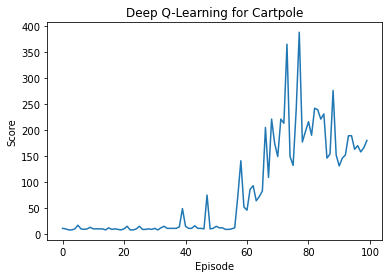

In [8]:
plt.plot(score_l)
plt.title("Deep Q-Learning for Cartpole")
plt.xlabel("Episode")
plt.ylabel("Score")

---
### 전체코드

Episode:     0 -->  Score: 125.0
Episode:     1 -->  Score: 30.0
Episode:     2 -->  Score: 31.0
Episode:     3 -->  Score: 18.0
Episode:     4 -->  Score: 9.0
Episode:     5 -->  Score: 13.0
Episode:     6 -->  Score: 13.0
Episode:     7 -->  Score: 12.0
Episode:     8 -->  Score: 9.0
Episode:     9 -->  Score: 17.0
Episode:    10 -->  Score: 21.0
Episode:    11 -->  Score: 21.0
Episode:    12 -->  Score: 76.0
Episode:    13 -->  Score: 120.0
Episode:    14 -->  Score: 10.0
Episode:    15 -->  Score: 11.0
Episode:    16 -->  Score: 9.0
Episode:    17 -->  Score: 8.0
Episode:    18 -->  Score: 10.0
Episode:    19 -->  Score: 9.0
Episode:    20 -->  Score: 11.0
Episode:    21 -->  Score: 14.0
Episode:    22 -->  Score: 10.0
Episode:    23 -->  Score: 47.0
Episode:    24 -->  Score: 41.0
Episode:    25 -->  Score: 63.0
Episode:    26 -->  Score: 35.0
Episode:    27 -->  Score: 84.0
Episode:    28 -->  Score: 55.0
Episode:    29 -->  Score: 47.0
Episode:    30 -->  Score: 58.0
Episode:   

Text(0, 0.5, 'Score')

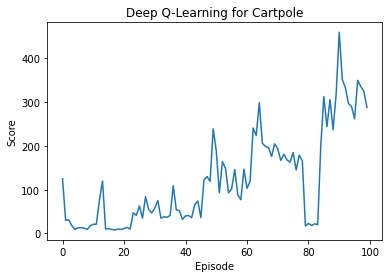

In [20]:
# 기본 패키지
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt 

# 강화학습 환경 패키지
import gym

# 인공지능 패키지: 텐서플로, 케라스 
# 호환성을 위해 텐스플로에 포함된 케라스를 불러옴 
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

def create_q_model(num_states, num_actions):
    inputs = Input(shape=(num_states,))
    layer = Dense(32, activation="relu")(inputs)
    layer = Dense(16, activation="relu")(layer)
    action = Dense(num_actions, activation="linear")(layer)
    return Model(inputs=inputs, outputs=action)

def list_rotate(l):
    return list(zip(*l))

class WorldFull():
    def __init__(self):
        self.get_env_model() #? 
        
        self.memory = deque(maxlen=2000)
        self.N_batch = 64
        self.t_model = create_q_model(self.num_states, self.num_actions)
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.optimizer = Adam(lr=self.learning_rate)
        
        self.epsilon = 0.2
        
    def get_env_model(self):
        self.env = gym.make('CartPole-v1')
        self.num_states = self.env.observation_space.shape[0]
        self.num_actions = self.env.action_space.n
        self.model = create_q_model(self.num_states, self.num_actions)
    
    def update_t_model(self):
        self.t_model.set_weights(self.model.get_weights())

    def best_action(self, s):
        if random.random() <= self.epsilon:
            return random.randrange(self.num_actions)
        else:
            s_array = np.array(s).reshape((1,-1))
            Qsa = self.model.predict(s_array)[0]
            return np.argmax(Qsa)

    def train_memory(self):
        if len(self.memory) >= self.N_batch:
            memory_batch = random.sample(self.memory, self.N_batch)
            s_l,a_l,r_l,next_s_l,done_l = [np.array(x) for x in list_rotate(memory_batch)]
            model_w = self.model.trainable_variables
            with tf.GradientTape() as tape:
                Qsa_pred_l = self.model(s_l.astype(np.float32))
                a_l_onehot = tf.one_hot(a_l, self.num_actions)
                Qs_a_pred_l = tf.reduce_sum(a_l_onehot * Qsa_pred_l, 
                                            axis=1)    

                Qsa_tpred_l = self.t_model(next_s_l.astype(np.float32)) 
                Qsa_tpred_l = tf.stop_gradient(Qsa_tpred_l)

                max_Q_next_s_a_l = np.amax(Qsa_tpred_l, axis=-1)
                Qs_a_l = r_l + (1 - done_l) * self.discount_factor * max_Q_next_s_a_l
                loss = tf.reduce_mean(tf.square(Qs_a_l - Qs_a_pred_l))
                grads = tape.gradient(loss, model_w)
                self.optimizer.apply_gradients(zip(grads, model_w))        
        
    def trials(self, n_episodes=100, flag_render=False):
        memory = self.memory
        env = self.env
        model = self.model
        score_l = []
        for e in range(n_episodes):
            done = False
            score = 0
            s = env.reset()
            while not done:                
                a = self.best_action(s)
                next_s, r, done, _ = env.step(a)
                if flag_render:
                    env.render()
                score += r
                memory.append([s,a,r,next_s,done])
                # self.train_memory()     
                s = next_s
                self.train_memory()                 
            self.update_t_model()
            print(f'Episode: {e:5d} -->  Score: {score:3.1f}') 
            score_l.append(score)            
        return score_l

new_world = WorldFull()
score_l = new_world.trials(n_episodes=100)
new_world.env.close()
np.save('score_l.npy', score_l)
print('Job completed!')

plt.plot(score_l)
plt.title("Deep Q-Learning for Cartpole")
plt.xlabel("Episode")
plt.ylabel("Score")

---
### 참고 자료

In [ ]:
logits = q_table[p][v]
# calculate the exponential of all elements in the input array.
logits_exp = np.exp(logits)
# calculate the probabilities
probabilities = logits_exp / np.sum(logits_exp)
# get random action
action = np.random.choice(environment.action_space.n, p=probabilities)
# get observation, reward and done after each step
observation, reward, done, _ = environment.step(action)